Fetch data (~52MB) from gdrive.

On ubuntu use `texlive-latex-extra texlive-fonts-recommended latexmk cm- dvipng` to install minimal set of latex packages (~500MB)

In [18]:
import gdown
import os

In [19]:
# !rm -rf .cache/
# !rm *.pdf

In [118]:
mode = 'pushevent_filter_promo'
# mode = 'forkevent_filter_promo'
# mode = 'regular'

result_path = ''
cache_path = '.cache'
os.makedirs(cache_path, exist_ok=True)
if mode == 'pushevent_filter_promo':
    result_path = os.path.join(cache_path, mode + '.json')
    gdown.cached_download('https://drive.google.com/file/d/1YQnYgbAj9Mpj8tVDkACI1vt_Z52FTEHD/view?usp=sharing',
                         result_path, fuzzy=True)
elif mode == 'regular':
    result_path = os.path.join(cache_path, mode + '.json')
    gdown.cached_download('https://drive.google.com/file/d/1QmPwhh8M5o8xL3L81uaw_sZ2L6b8OFn0/view?usp=sharing',
                         result_path, fuzzy=True)
elif mode == 'forkevent_filter_promo':
    result_path = os.path.join(cache_path, mode + '.json')
    gdown.cached_download('https://drive.google.com/file/d/1JBJH0aum6Cl7O_biu_xe_7BWTn_-S46v/view?usp=sharing',
                         result_path, fuzzy=True)
else:
    raise Exception('unknown mode ' + mode)

Cached Downloading: .cache/pushevent_filter_promo.json
Downloading...
From: https://drive.google.com/uc?id=1YQnYgbAj9Mpj8tVDkACI1vt_Z52FTEHD
To: /home/leonhard/.cache/gdown/tmp6hnaq8mf/dl
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.62M/5.62M [00:01<00:00, 4.29MB/s]


In [119]:
ylims_mem = {'regular' : (0, 16000), 'pushevent_filter_promo' : (0, 1600),
             'forkevent_filter_promo' : (0, 400)}
ylims_complexity = {'regular' : (0, 1200), 'pushevent_filter_promo' : (0, 120),
                    'forkevent_filter_promo': (0, 120)}

In [120]:
#result_path =  '/Users/leonhards/projects/tuplex-public/tuplex/cmake-build-release/dist/bin/experiment_result.json'

In [121]:
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.ticker
from paper import *

In [122]:
adjust_settings()

In [123]:
with open(result_path, 'r') as fp:
    data = fp.read()

In [124]:
lines = data.strip().split('\n')
len(lines)

22

In [125]:
d = [json.loads(line) for line in lines]
df = pd.DataFrame(d)

In [126]:
df.columns

Index(['buf_size_compressed', 'buf_size_uncompressed', 'event_to_filter_for',
       'fallback_mem', 'fallback_rows', 'filter_promotion', 'filtered_rows',
       'general_case', 'general_case_field_count', 'general_case_pretty',
       'general_json_paths', 'general_mem', 'general_rows', 'mode',
       'normal_case', 'normal_case_field_count', 'normal_case_pretty',
       'normal_json_paths', 'normal_mem', 'normal_rows', 'path',
       'perfect_sample', 'sample', 'sample_row_count', 'sample_size',
       'total_rows', 'type_counts'],
      dtype='object')

In [127]:
df['year'] = df['path'].apply(lambda x: x.replace('.json.gz', '')).apply(lambda x: x[x.rfind('/')+1:].split('-')[0]).astype(int)

In [128]:
df[df['mode'] == 'hyper'].sort_values(by=['year'])['total_rows']

10      48899
9      165692
8      296456
7      476393
6      737714
5      678134
4      910100
3     1522655
2     2134789
1     2963694
0     1078139
Name: total_rows, dtype: int64

In [129]:
df[df['mode'] == 'global'].sort_values(by=['year'])['total_rows']

21      48899
20     165692
19     296456
18     476393
17     737714
16     678134
15     910100
14    1522655
13    2134789
12    2963694
11    1078139
Name: total_rows, dtype: int64

sanity check done, now let's plot them next to each other

In [130]:
df_hyper = df[df['mode'] == 'hyper'].sort_values(by=['year'])
df_global = df[df['mode'] == 'global'].sort_values(by=['year'])

plot nice overview over data

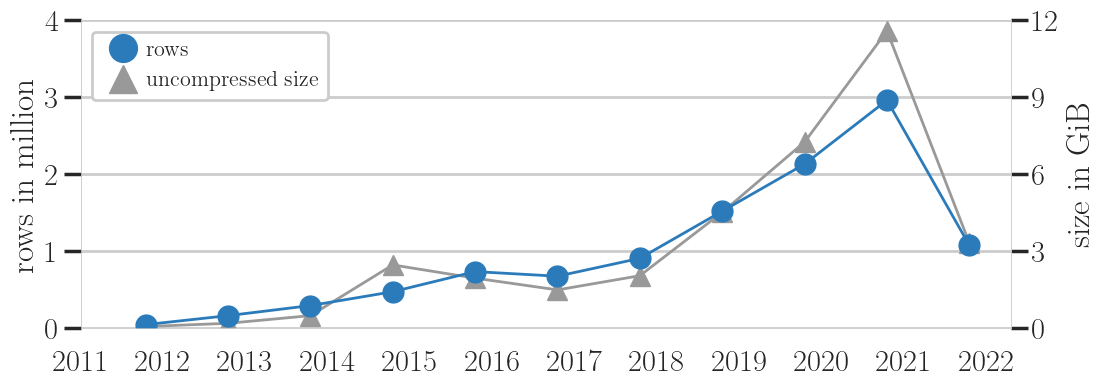

In [131]:
plt.figure(figsize=(12, 4))

primary_col = sns.color_palette('Blues')[-2]
secondary_col = [0.6]*3


ax1 = plt.gca()
xq = np.arange(len(df_global))
oct_offset = 288/365 # ignore leap year
ax1.plot(xq + oct_offset, df_global['total_rows'] / 10**6, marker='o',
         color=primary_col, markersize=15, linewidth=2)

ax1.set_ylabel('rows in million')
ax1.set_ylim(0, 4)
xt = np.array([0, 1, 2, 3, 4])
ax1.set_yticks(xt)
ax2 = ax1.twinx()
ax2.plot(xq + oct_offset, df_global['buf_size_uncompressed'] / (1024**3),
         color=secondary_col, marker='^', markersize=15,
        linewidth=2)
ax2.set_ylim(0, 12)
ax2.set_yticks(xt * 3)
ax2.set_ylabel('size in GiB')

# fix for ordering
ax2.zorder=0
ax1.zorder=1
ax1.patch.set_visible(False)

lgd_handles = []
lgd_handles.append(Line2D([0], [0], marker='o', color=primary_col, label='rows',
                   markerfacecolor=primary_col, markersize=20, linewidth=0))
lgd_handles.append(Line2D([0], [0], marker='^', color=secondary_col, label='uncompressed size',
                   markerfacecolor=secondary_col, markersize=20, linewidth=0))
ax1.legend(loc='upper left', handles=lgd_handles, fontsize=16, handletextpad=0.05, facecolor='w', framealpha=1)

#sns.despine()
xq = np.arange(len(df_global) + 1)

# ax1.grid(axis='y')
ax1.grid(False)
# ax2.grid(axis='x')
plt.xticks(xq, list(df_global['year'].values) + ['2022'], visible=True, rotation="vertical")
plt.savefig(mode + '_peryear_data_overview.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

plot number of fields over years

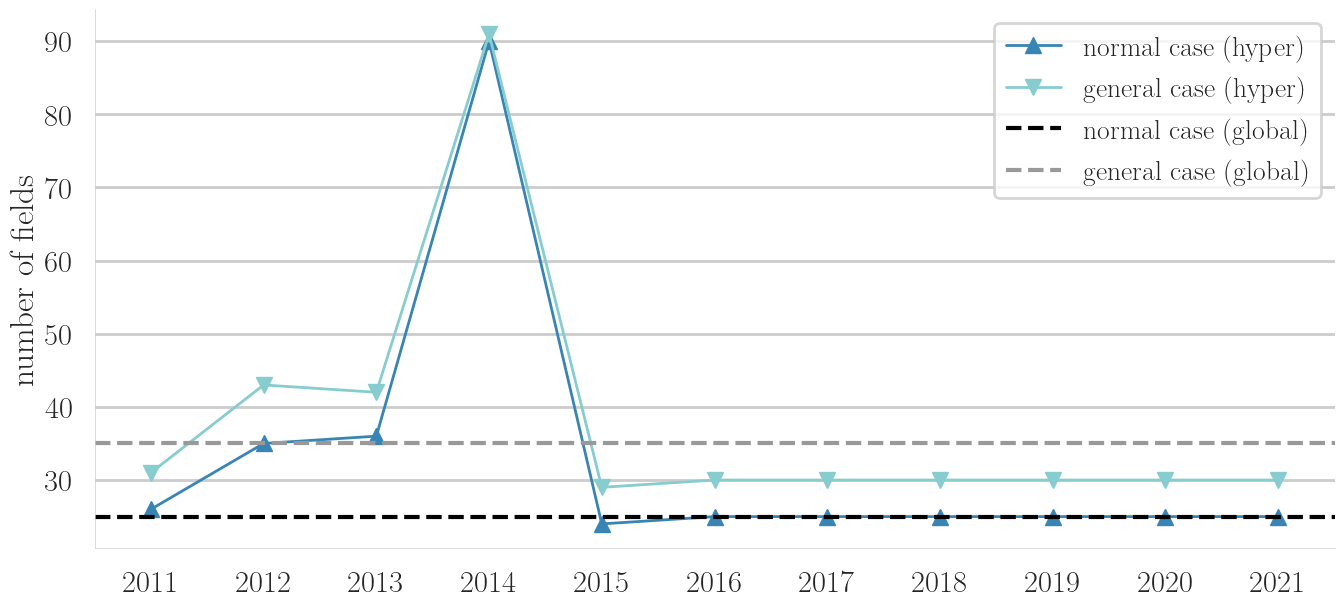

In [132]:
plt.figure(figsize=(16,7))
plt.plot(df_hyper['year'], df_hyper['normal_case_field_count'],
         marker='^', linewidth=2, label='normal case (hyper)')
plt.plot(df_hyper['year'], df_hyper['general_case_field_count'],
         marker='v', linewidth=2, label='general case (hyper)')
plt.axhline(df_global['normal_case_field_count'].iloc[0], linewidth=3,
            linestyle='--',
            color='k', label='normal case (global)')
plt.axhline(df_global['general_case_field_count'].iloc[0], linewidth=3, linestyle='--',
            color=[0.6]*3, label='general case (global)')
plt.legend(fontsize=20)
if mode == 'regular':
    plt.yscale('log')
    plt.yticks([1, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000])
    plt.ylim([10, 1500])
    
plt.xticks(df_hyper['year'])

def fmt(x, pos):
    return str(int(x))
ax = plt.gca()
#ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 10 ** 7, 0.5 * 10**6)))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))

sns.despine()
plt.grid(axis='x')
plt.ylabel('number of fields')
plt.savefig(mode + '_peryear_schema_complexity.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

TODO: Could potentially add to this graph the most complex and least complex schema actually found in the data...

--> this is basically a lower and upper bound

In [133]:
# general case complexity:
print('normal  case (global): {} fields'.format(df_global['normal_case_field_count'].iloc[0]))
print('general case (global): {} fields'.format(df_global['general_case_field_count'].iloc[0]))

normal  case (global): 25 fields
general case (global): 35 fields


In [134]:
# normal case complexity
print('normal  case (hyper): {} - {} fields'.format(df_hyper['normal_case_field_count'].min(),
                                                   df_hyper['normal_case_field_count'].max()))
print('general case (hyper): {} - {} fields'.format(df_hyper['general_case_field_count'].min(),
                                                   df_hyper['general_case_field_count'].max()))

normal  case (hyper): 24 - 90 fields
general case (hyper): 29 - 91 fields


In [135]:
df_hyper[df_hyper['year'] == 2014][['normal_mem', 'general_mem', 'fallback_mem']]

,normal_mem,general_mem,fallback_mem
7,8438752,9730715,1102230118


In [136]:
df_hyper[df_hyper['year'] == 2014][['normal_rows', 'general_rows', 'fallback_rows']]

,normal_rows,general_rows,fallback_rows
7,240251,2245,233897


In [137]:
df_hyper[['normal_rows', 'filtered_rows']]

,normal_rows,filtered_rows
10,31937,24825
9,88848,87720
8,153618,151527
7,240251,238381
6,737714,387090
5,678134,305636
4,910100,391341
3,1522655,735258
2,2134789,1089230
1,2963694,1401945


In [138]:
def plot_bars(subdf, xoff, w, c1, c2, c3):
    xq = np.arange(len(subdf))
    
    has_filtered_rows = 'filtered_rows' in subdf.columns and subdf['filtered_rows'].sum() > 0
    print(has_filtered_rows)
    
    if has_filtered_rows:
        fr = subdf['filtered_rows'].copy()
        nr = subdf['normal_rows'].copy()
        nr -= fr
        gr = subdf['general_rows'].copy()
        fb = subdf['fallback_rows'].copy()
        plt.bar(xq + xoff, nr,  w, color=c1)
        plt.bar(xq + xoff, gr, w, bottom=nr, color=c2)
        plt.bar(xq + xoff, fb, w, bottom=nr + gr, color=c3)
    else:
        plt.bar(xq + xoff, subdf['normal_rows'],  w, color=c1)
        plt.bar(xq + xoff, subdf['general_rows'], w, bottom=subdf['normal_rows'], color=c2)
        plt.bar(xq + xoff, subdf['fallback_rows'], w, bottom=subdf['normal_rows'] + subdf['general_rows'], color=c3)
    
def plot_bars_mem(subdf, xoff, w, mem_factor, c1, c2, c3):
    xq = np.arange(len(subdf))
    plt.bar(xq + xoff, subdf['normal_mem'] / mem_factor,  w, color=c1)
    plt.bar(xq + xoff, subdf['general_mem'] / mem_factor, w, bottom=subdf['normal_mem'] / mem_factor, color=c2)
    plt.bar(xq + xoff, subdf['fallback_mem'] / mem_factor, w, bottom=subdf['normal_mem']  / mem_factor + subdf['general_mem']  / mem_factor, color=c3)

True
True
done


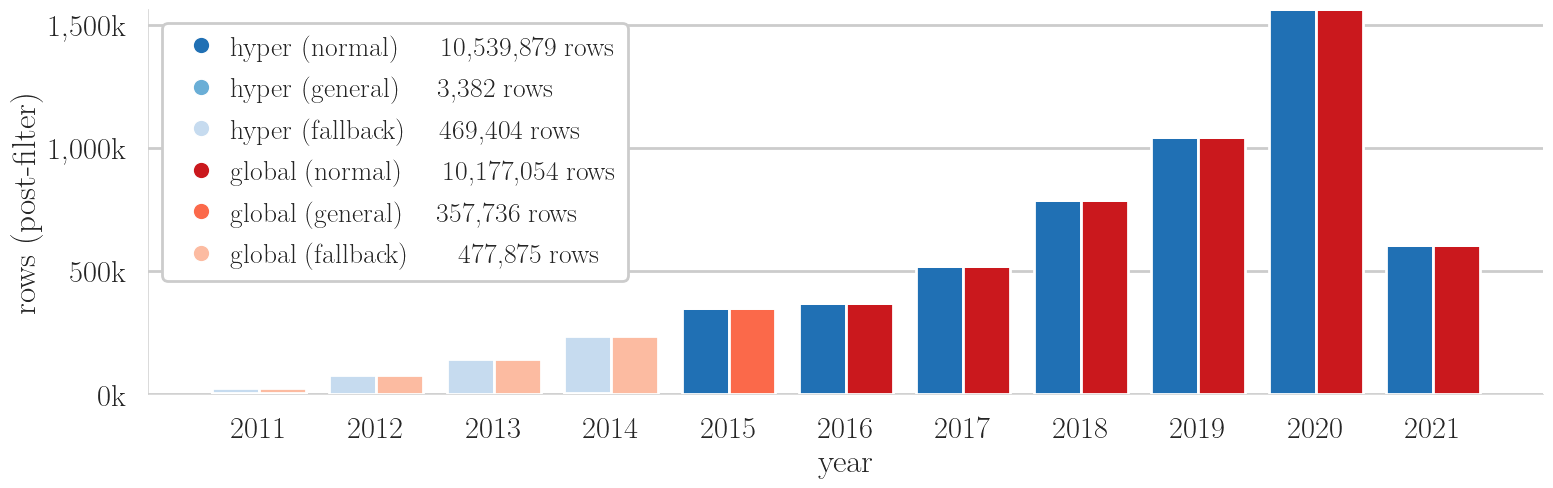

In [139]:
plt.figure(figsize=(18, 5))
handles =[]
c1, c2, c3 = sns.color_palette('Blues', 3)[::-1]
plot_bars(df_hyper, -.2, 0.4, c1, c2 , c3)
normal = df_hyper['normal_rows'].sum()
general = df_hyper['general_rows'].sum()
fallback = df_hyper['fallback_rows'].sum()
handles += [(f'hyper (normal)    \\,\\,\\quad{normal:,} rows', c1),
            (f'hyper (general)   \\,\\quad{general:,} rows', c2),
            (f'hyper (fallback)  \\quad {fallback:,} rows', c3)]
c1, c2, c3 = sns.color_palette('Reds', 3)[::-1]
normal =   df_global['normal_rows'].sum()
general =  df_global['general_rows'].sum()
fallback = df_global['fallback_rows'].sum()
handles += [(f'global (normal)   \\;\\,\\,\\,\\, {normal:,} rows', c1),
            (f'global (general)  \\quad {general:,} rows', c2),
            (f'global (fallback) \\quad\; {fallback:,} rows', c3)]
plot_bars(df_global, .2, 0.4, c1, c2, c3)
xq = np.arange(len(df_hyper))
plt.xticks(xq, df_hyper['year'])
print('done')
sns.despine()

has_filtered_rows = 'filtered_rows' in df.columns and df['filtered_rows'].sum() > 0
if has_filtered_rows:
    plt.ylabel('rows (post-filter)')
else:
    plt.ylabel('rows')
plt.xlabel('year')

plt.grid(axis='x')

# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
lgd_handles=[]
for h in handles:
    lgd_handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                        markerfacecolor=h[1], markersize=12))
ax = plt.gca()
ax.legend(loc='best', handles=lgd_handles, fontsize=20, handletextpad=0.05, facecolor='w', framealpha=1)

def fmt(x, pos):
    k = int(x / 10**3)
    return  f'{k:,}' + 'k'

#ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 10 ** 7, 0.5 * 10**6)))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))
#ax.tick_params(which = 'major', length = 25)

plt.savefig(mode + '_peryear_data_fullschema.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

done


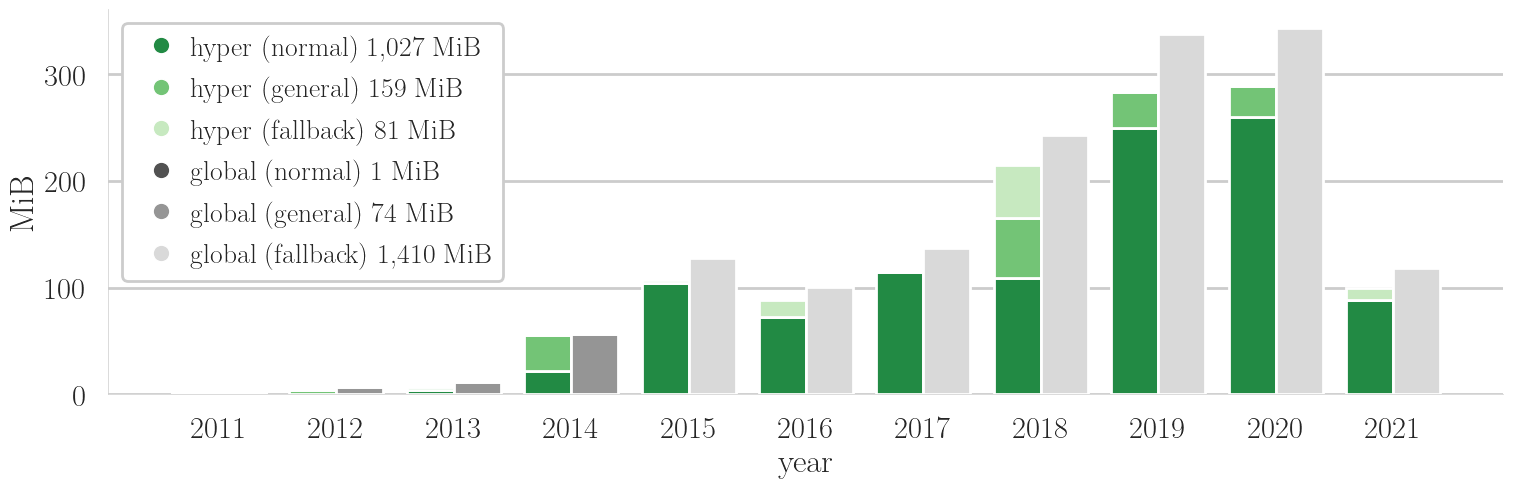

In [117]:
plt.figure(figsize=(18, 5))
handles =[]
c1, c2, c3 = sns.color_palette('Greens', 3)[::-1]
mem_factor = 1024 * 1024
mem_unit = 'MiB'
plot_bars_mem(df_hyper, -.2, 0.4, mem_factor, c1, c2 , c3)
normal = int(df_hyper['normal_mem'].sum() / mem_factor)
general = int(df_hyper['general_mem'].sum() / mem_factor)
fallback = int(df_hyper['fallback_mem'].sum() / mem_factor)
handles += [(f'hyper (normal)    {normal:,} {mem_unit}', c1),
            (f'hyper (general)   {general:,} {mem_unit}', c2),
            (f'hyper (fallback)  {fallback:,} {mem_unit}', c3)]
c1, c2, c3 = sns.color_palette('Greys', 3)[::-1]
normal =   int(df_global['normal_mem'].sum() / mem_factor)
general =  int(df_global['general_mem'].sum() / mem_factor)
fallback = int(df_global['fallback_mem'].sum() / mem_factor)
handles += [(f'global (normal)    {normal:,} {mem_unit}', c1),
            (f'global (general)     {general:,} {mem_unit}', c2),
            (f'global (fallback) {fallback:,} {mem_unit}', c3)]
plot_bars_mem(df_global, .2, 0.4, mem_factor, c1, c2, c3)
xq = np.arange(len(df_hyper))
plt.xticks(xq, df_hyper['year'])
print('done')
sns.despine()
plt.ylabel(mem_unit)
plt.xlabel('year')

plt.grid(axis='x')

# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
lgd_handles=[]
for h in handles:
    lgd_handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                        markerfacecolor=h[1], markersize=12))
ax = plt.gca()
ax.legend(loc='best', handles=lgd_handles, fontsize=20, handletextpad=0.05, facecolor='w', framealpha=1)
plt.savefig(mode + '_peryear_data_fullschema_memory.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

In [47]:
# interpolation for full dataset (pretty off)
hyper_total = df_hyper['normal_mem'].sum() + df_hyper['general_mem'].sum() + df_hyper['fallback_mem'].sum()
global_total = df_global['normal_mem'].sum() + df_global['general_mem'].sum() + df_global['fallback_mem'].sum()

print('memory usage:: hyper {:.1f} MiB  global {:.1f} MiB'.format(
    hyper_total / mem_factor, global_total / mem_factor))

print('memory usage:: hyper {:.1f} GiB  global {:.1f} GiB'.format(
    hyper_total / (mem_factor * 1024), global_total / (mem_factor * 1024)))

memory usage:: hyper 1268.7 MiB  global 1486.5 MiB
memory usage:: hyper 1.2 GiB  global 1.5 GiB


In [48]:
pct_reduction = 100.0 * (1.0 - hyper_total / global_total)
print('hyper reduced overall footprint by {}%'.format(pct_reduction))

hyper reduced overall footprint by 14.651872664052911%


In [49]:
# averages per row may be also interesting:

print('encoding 1 row in normal   (hyper): {:.2f} Kib'.format(
    df_hyper['normal_mem'].sum() / df_hyper['normal_rows'].sum() / 1024))
print('encoding 1 row in general  (hyper): {:.2f} Kib'.format(
    df_hyper['general_mem'].sum() / df_hyper['general_rows'].sum() / 1024))
print('encoding 1 row in fallback (hyper): {:.2f} Kib'.format(
    df_hyper['fallback_mem'].sum() / df_hyper['fallback_rows'].sum() / 1024))
print('----')
print('encoding 1 row in normal   (global): {:.2f} Kib'.format(
    df_global['normal_mem'].sum() / df_global['normal_rows'].sum() / 1024))
print('encoding 1 row in general  (global): {:.2f} Kib'.format(
    df_global['general_mem'].sum() / df_global['general_rows'].sum() / 1024))
print('encoding 1 row in fallback (global): {:.2f} Kib'.format(
    df_global['fallback_mem'].sum() / df_global['fallback_rows'].sum() / 1024))

encoding 1 row in normal   (hyper): 0.10 Kib
encoding 1 row in general  (hyper): 3.79 Kib
encoding 1 row in fallback (hyper): 5.57 Kib
----
encoding 1 row in normal   (global): 0.00 Kib
encoding 1 row in general  (global): 2.39 Kib
encoding 1 row in fallback (global): 5.53 Kib


How many unique normal-cases exist in hyper?

In [50]:
len(df_hyper['normal_case'].unique()), len(df_global['normal_case'].unique())

(10, 1)

How many unique general-cases exist in hyper?

In [51]:
len(df_hyper['general_case'].unique()), len(df_global['general_case'].unique())

(11, 1)

some more analysis (specific for promotion)

In [52]:
df_hyper[['year', 'normal_rows', 'general_rows', 'fallback_rows']]

,year,normal_rows,general_rows,fallback_rows
10,2011,48690,0,209
9,2012,160735,4912,45
8,2013,291944,4144,368
7,2014,466690,9441,262
6,2015,737203,0,511
5,2016,675186,0,2948
4,2017,910100,0,0
3,2018,1501991,12150,8514
2,2019,2128101,6688,0
1,2020,2957971,5723,0


In [53]:
df_global[['year', 'normal_rows', 'general_rows', 'fallback_rows']]

,year,normal_rows,general_rows,fallback_rows
21,2011,48690,0,209
20,2012,159785,5862,45
19,2013,285828,10260,368
18,2014,460379,15752,262
17,2015,712413,0,25301
16,2016,658722,0,19412
15,2017,883993,0,26107
14,2018,1478251,0,44404
13,2019,2073452,0,61337
12,2020,2901340,0,62354


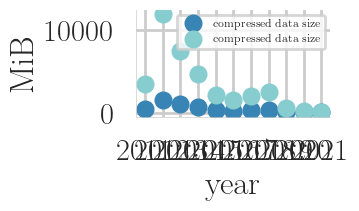

In [54]:
plt.plot(df_hyper['buf_size_compressed'] / mem_factor, 'o', label='compressed data size')
plt.plot(df_hyper['buf_size_uncompressed'] / mem_factor, 'o', label='compressed data size')
plt.xticks(xq, df_hyper['year'])
sns.despine()
plt.ylabel(mem_unit)
plt.xlabel('year')

plt.legend(loc='best')

In [55]:
# require filter promotion etc. to get a better fit? E.g., a restrictive filter on years 2015 and 2016 could do.

In [56]:
# least complex normal-case
sorted(list(df['normal_case'].values), key=len)[0]

"Struct[(str,'created_at'->str),(str,'payload'->{}),(str,'public'->boolean),(str,'type'->str),(str,'url'->str),(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'login'->str),(str,'type'->str),(str,'gravatar_id'->str),(str,'email'->str)]),(str,'repository'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str),(str,'description'->str),(str,'homepage'->str),(str,'watchers'->i64),(str,'stargazers'->i64),(str,'forks'->i64),(str,'fork'->boolean),(str,'size'->i64),(str,'owner'->str),(str,'private'->boolean),(str,'open_issues'->i64),(str,'has_issues'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'language'->str),(str,'created_at'->str),(str,'pushed_at'->str),(str,'master_branch'->str)])]"

In [57]:
# most complex normal-case
sorted(list(df['normal_case'].values), key=len)[-1]

"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'forkee'->Struct[(str,'allow_forking'->boolean),(str,'archive_url'->str),(str,'archived'->boolean),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'deployments_url'->str),(str,'description'->Option[str]),(str,'disabled'->boolean),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_url'->str),(str,'git_tags_url'->str),(str,'git_url'->str),(str,'h

In [58]:
# least complex general_case
sorted(list(df['general_case'].values), key=len)[0]

"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->{}),(str,'public'->boolean),(str,'repository'->Struct[(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'homepage'=>str),(str,'id'->i64),(str,'integrate_branch'=>str),(str,'language'=>str),(str,'master_branch'->str),(str,'name'->str),(str,'open_issues'->i64),(str,'organization'=>str),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]"

In [59]:
# most complex general_case
sorted(list(df['general_case'].values), key=len)[-1]

"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'forkee'->Struct[(str,'allow_forking'->boolean),(str,'archive_url'->str),(str,'archived'->boolean),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'deployments_url'->str),(str,'description'->Option[str]),(str,'disabled'->boolean),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full

In [60]:
df_global['normal_case'].iloc[0]

"Struct[(str,'actor'->Struct[(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str),(str,'id'->i64),(str,'login'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'forkee'->Struct[(str,'clone_url'->str),(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'git_url'->str),(str,'homepage'->str),(str,'html_url'->str),(str,'id'->i64),(str,'language'->Option[str]),(str,'master_branch'->null),(str,'name'->str),(str,'open_issues'->i64),(str,'owner'->Struct[(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'private'->boolean),(str,'public'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'svn_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64)])]),(str,'public'->boolean),(str,'repo'->Struct[(str,'url'->str),(str,'id'->i64),(str,'name'->str)]),(str,'type'->str)]"

In [61]:
df_global['general_case'].iloc[0]

"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->{}),(str,'public'->boolean),(str,'repository'->Struct[(str,'archive_url'=>str),(str,'assignees_url'=>str),(str,'blobs_url'=>str),(str,'branches_url'=>str),(str,'clone_url'=>str),(str,'collaborators_url'=>str),(str,'comments_url'=>str),(str,'commits_url'=>str),(str,'compare_url'=>str),(str,'contents_url'=>str),(str,'contributors_url'=>str),(str,'created_at'->str),(str,'default_branch'=>str),(str,'description'->str),(str,'downloads_url'=>str),(str,'events_url'=>str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'=>i64),(str,'forks_url'=>str),(str,'full_name'=>str),(str,'git_commits_url'=>str),(str,'git_refs_url'=>str),(str,'git_tags_url'=>str),(str,'git_url'=>str),(str,'has_downloads'->boolean),(str,'has_issues'->boolea

Maybe the question could be? How do stars and forks coincide? I.e. how many stars does one need so the repo gets forked?

Another interesting question could be to find active forks?
This means, forks that have stars/watchers and other forks!

--> perhaps this is a self-join?

In [62]:
# !open .

In [63]:
df_hyper['total_rows']

10      48899
9      165692
8      296456
7      476393
6      737714
5      678134
4      910100
3     1522655
2     2134789
1     2963694
0     1078139
Name: total_rows, dtype: int64

In [64]:
# -> prob. picks up the wrong normal-case/global case... -> selection routine may be off...

Improvements:
    
    - pick specific day (October 15th :P?)
    - combine data for the day (so it's larger)
    - rerun this experiment

Observations: 

    -> why is there nearly no general-case matching in the global specialization case?

--> perform pushdown (PushEvent?)

--> then map function

Notes:

--> does maybe adding keycheck change things?

In [ ]:
nc = df_hyper[df_hyper['year'] == 2014]['normal_case'].iloc[0]
nc[nc.find('payload'):]

In [ ]:
nc = df_hyper[df_hyper['year'] == 2013]['normal_case'].iloc[0]
nc[nc.find('payload'):]

In [ ]:
nc = df_hyper[df_hyper['year'] == 2015]['normal_case'].iloc[0]
nc[nc.find('payload'):]

To answer: What happened in 2014?

what happened in 2015 for global sample?

In [ ]:
df_hyper[['year', 'sample_row_count']]

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_hyper['year'], df_hyper['sample_row_count'], marker='x')

In [ ]:
df_global['sample_row_count'].iloc[0]

In [ ]:
df_hyper.columns

=> increase sample size. => fix number of rows for sampling, e.g. 2000 rows (then also same number of rows for global? i.e. 200 each?)


=> check why pushevent rows prior to 2015 end up on fallback case for hyper specialization.

In [ ]:
df_global[['year', 'normal_mem', 'general_mem', 'fallback_mem']]

--> no idea what is going on in 2015. Shouldn't half of data be on normal-case?

add in filter promo chart. another bar to tell the normal/filtered out rows.

In [ ]:
df_global['normal_case'].iloc[0]

In [ ]:
df_global['general_case'].iloc[0]

maybe add some sample data to this.

Another driver for (current) global:

    All files are equally weighted.